## **Домашнее задание "Сингулярный спектральный анализ"**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ._.DS_Store to ._.DS_Store
Saving ._~$Модели авторегрессии условной гетероскедантичности.pptx to ._~$Модели авторегрессии условной гетероскедантичности.pptx
Saving ._international-airline-passengers.csv to ._international-airline-passengers.csv
Saving ._monthly-boston-armed-robberies-j.csv to ._monthly-boston-armed-robberies-j.csv
Saving .DS_Store to .DS_Store
Saving ~$Модели авторегрессии условной гетероскедантичности.pptx to ~$Модели авторегрессии условной гетероскедантичности.pptx
Saving lecture-2-part-1.ipynb to lecture-2-part-1.ipynb
Saving lecture-2-part-2.ipynb to lecture-2-part-2.ipynb
Saving monthly-boston-armed-robberies-j.csv to monthly-boston-armed-robberies-j.csv
Saving Модели авторегрессии условной гетероскедантичности.pptx to Модели авторегрессии условной гетероскедантичности.pptx


In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [3]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [11]:
from google.colab import files
uploaded = files.upload()

Saving .DS_Store to .DS_Store (1)
Saving data_subjects_info.csv to data_subjects_info.csv
Saving introducing-ssa-for-time-series-decomposition.ipynb to introducing-ssa-for-time-series-decomposition.ipynb


In [12]:
from google.colab import files
uploaded = files.upload()

Saving sub_1.csv to sub_1.csv
Saving sub_2.csv to sub_2.csv
Saving sub_3.csv to sub_3.csv
Saving sub_4.csv to sub_4.csv
Saving sub_5.csv to sub_5.csv
Saving sub_6.csv to sub_6.csv
Saving sub_7.csv to sub_7.csv
Saving sub_8.csv to sub_8.csv
Saving sub_9.csv to sub_9.csv
Saving sub_10.csv to sub_10.csv
Saving sub_11.csv to sub_11.csv
Saving sub_12.csv to sub_12.csv
Saving sub_13.csv to sub_13.csv
Saving sub_14.csv to sub_14.csv
Saving sub_15.csv to sub_15.csv
Saving sub_16.csv to sub_16.csv
Saving sub_17.csv to sub_17.csv
Saving sub_18.csv to sub_18.csv
Saving sub_19.csv to sub_19.csv
Saving sub_20.csv to sub_20.csv
Saving sub_21.csv to sub_21.csv
Saving sub_22.csv to sub_22.csv
Saving sub_23.csv to sub_23.csv
Saving sub_24.csv to sub_24.csv


In [16]:
from google.colab import files
uploaded = files.upload()

Saving ._.DS_Store to ._ (1).DS_Store
Saving ._A_DeviceMotion_data to ._A_DeviceMotion_data
Saving ._data_subjects_info.csv to ._data_subjects_info.csv
Saving ._introducing-ssa-for-time-series-decomposition.ipynb to ._introducing-ssa-for-time-series-decomposition.ipynb


In [17]:
from google.colab import files
uploaded = files.upload()

Saving .___MACOSX to .___MACOSX
Saving ._A_DeviceMotion_data to ._A_DeviceMotion_data (1)


In [18]:
from google.colab import files
uploaded = files.upload()

Saving ._A_DeviceMotion_data to ._A_DeviceMotion_data (2)


In [21]:
walk_1 = pd.read_csv("sub_1.csv")

In [22]:
cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
accel_1 = (walk_1[cols]**2).sum(axis=1)**0.5
accel_1.index /= 50

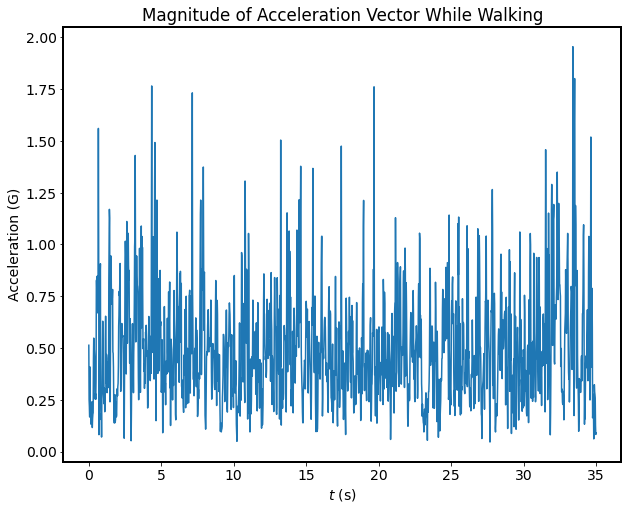

In [23]:
accel_1.plot()
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.title("Magnitude of Acceleration Vector While Walking");

Text(0, 0.5, 'Acceleration (G)')

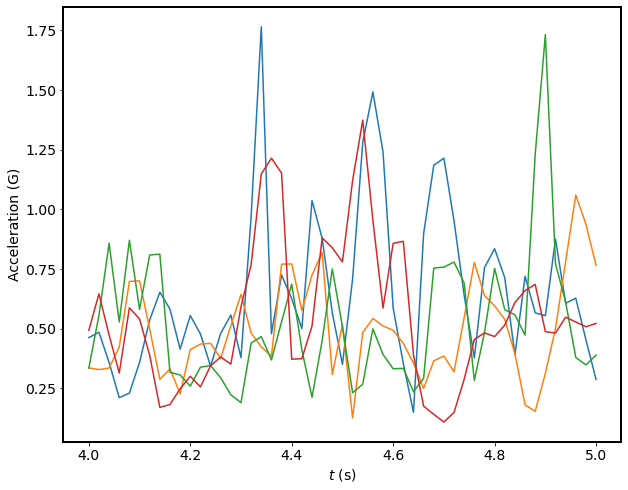

In [24]:
accel_1.loc[4:5].plot()
accel_1.shift(-56).loc[4:5].plot()
accel_1.shift(-112).loc[4:5].plot()
accel_1.shift(-168).loc[4:5].plot()

plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")

In [25]:
start = 10
end = 25
window = 350
accel_ssa = SSA(accel_1.loc[start:end], window)

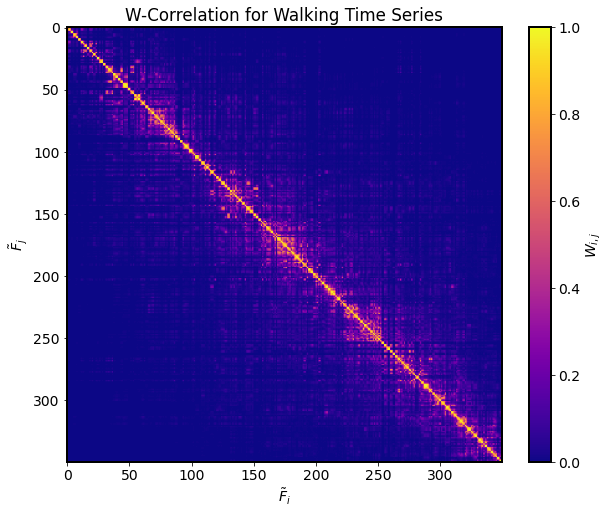

In [26]:
accel_ssa.plot_wcorr()
plt.title("W-Correlation for Walking Time Series");

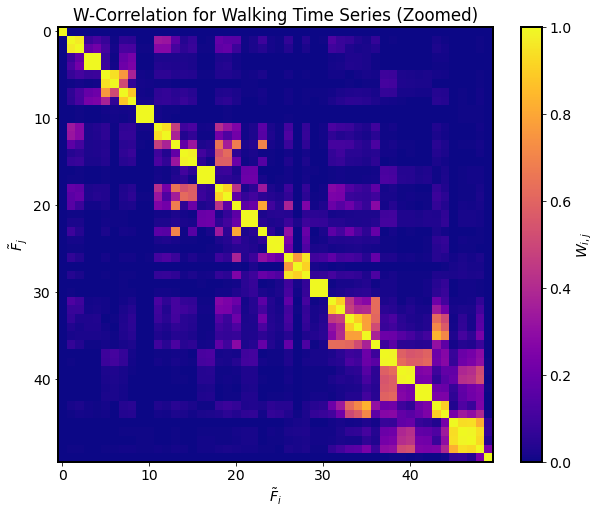

In [27]:
accel_ssa.plot_wcorr(max=49)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

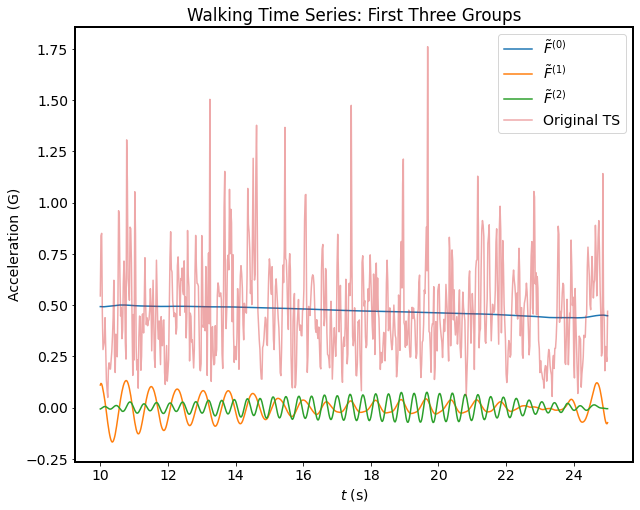

In [28]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

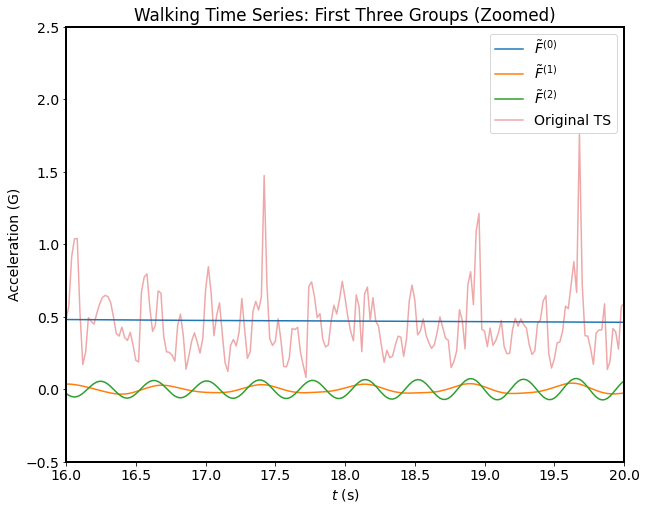

In [29]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: First Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(-0.5, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

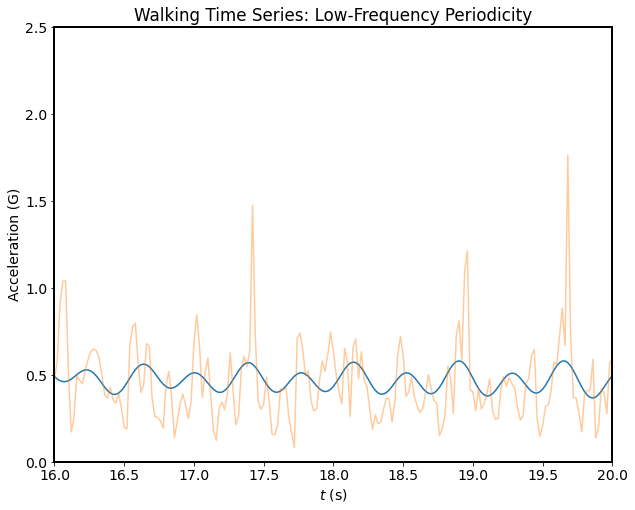

In [30]:
accel_ssa.reconstruct(slice(0,5)).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Low-Frequency Periodicity")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(0, 2.5);

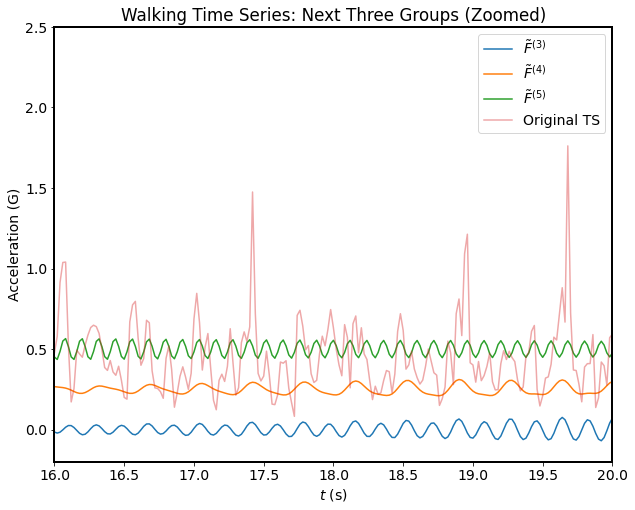

In [32]:
accel_ssa.reconstruct([5,6]).plot()
(accel_ssa.reconstruct([7,8]) + 0.25).plot()
(accel_ssa.reconstruct([9,10]) + 0.5).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: Next Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(16,20)
plt.ylim(-0.2, 2.5)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

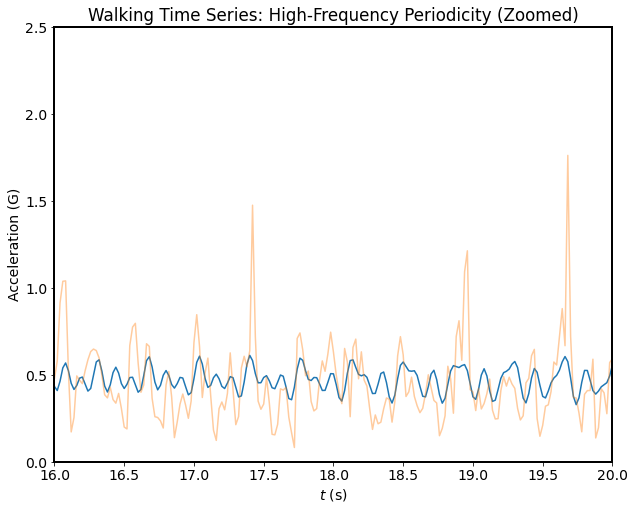

In [33]:
accel_ssa.reconstruct([0] + [i for i in range(5,11)]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: High-Frequency Periodicity (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.ylim(0, 2.5)
plt.xlim(16,20);

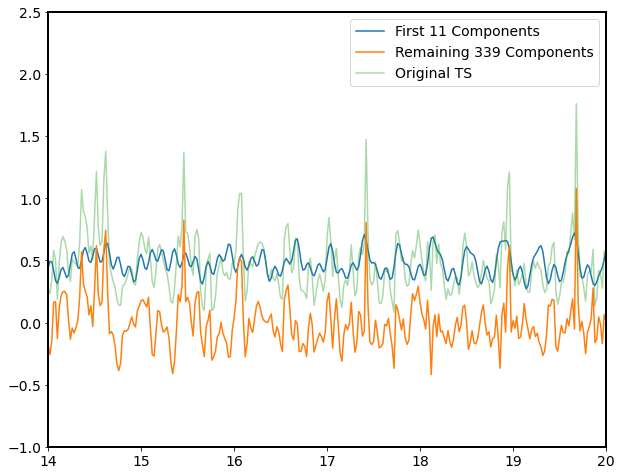

In [34]:
accel_ssa.reconstruct(slice(0,11)).plot()
accel_ssa.reconstruct(slice(11,350)).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.ylim(-1, 2.5)
plt.xlim(14,20)
plt.legend(["First 11 Components", "Remaining 339 Components", "Original TS"]);